## Classification: Decision tree, Random forest

* Use a method of your choice to train a random forest to predict the variable **fraud_reported** in the dataset **fraud_claims.csv**. This target variable is binary.
* Visualise the generated random forest (overview map) and five selected decision trees (with values).
* Choose a meaningful criterion to prove how well your random forest predicts the variable **fraud_reported**.
* Justify the choice of split criterion and category encoding

### Resources:
* Scikit-learn Docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


My to do:
- resample so that negative/positive balance is (the same result can be done with class_weights=balanced)
- avoid oversampling with SMOTE algorithm: https://imbalanced-learn.org/stable/
- calculate true positive rate (sensitivity) on test data
- precision recall 
- visualize importance of features
- random forest bootstrapping
- boosting, XGBoost, adaptation
1. Parameters suchen 
2. Hyperparameter tuning
3. Ergebnisse evaluieren

With neural net it is important to have balanced dataset

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from scipy.stats import randint

In [2]:
df = pd.read_csv('fraud_claims.csv')
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.80,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


### Explore the variables in the dataset

In [9]:
df.describe()   #automatically take the numerische Variablen

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


In [4]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

In [3]:
df.columns.where(df.dtypes != 'object') #only look at the variables that are not string

Index([         'months_as_customer',                         'age',
                     'policy_number',                           nan,
                                 nan,                           nan,
                 'policy_deductable',       'policy_annual_premium',
                    'umbrella_limit',                 'insured_zip',
                                 nan,                           nan,
                                 nan,                           nan,
                                 nan,               'capital-gains',
                      'capital-loss',                           nan,
                                 nan,                           nan,
                                 nan,                           nan,
                                 nan,                           nan,
                                 nan,    'incident_hour_of_the_day',
       'number_of_vehicles_involved',                           nan,
                   'bodily_injurie

In [14]:
df_numerical = df.select_dtypes(include=np.number)

In [4]:
df['fraud_reported'] = df['fraud_reported'].map({'N':0,'Y':1})
df['police_report_available'] = df['police_report_available'].map({'?':0,'YES':1,'NO':0})

### Split training and testing datasets

In [5]:
# Split the data into features (X) and target (y)
X = df[['policy_annual_premium','witnesses','age','policy_deductable','umbrella_limit','police_report_available','capital-gains','capital-loss','total_claim_amount','injury_claim','property_claim','vehicle_claim','auto_year']]
y = df['fraud_reported']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Train and predict with random forest to detect fraud

In [6]:
model = RandomForestClassifier(random_state= 0, bootstrap=True, max_depth=2 ) #control the randomness of bootstrapping
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.755


In [7]:
model.feature_importances_ #capital-loss is the most important feature according to Gini importance
#The values of this array sum to 1

array([0.04431875, 0.01957862, 0.0573598 , 0.00985983, 0.02419662,
       0.00339582, 0.06971045, 0.03336427, 0.22978771, 0.09390577,
       0.17958875, 0.20798503, 0.02694859])

This means that each tree only knows about the data pertaining to a small constant number of features, and a variable number of samples that is less than or equal to that of the original dataset. n a random forest, each tree "votes" on whether or not to classify a sample as positive based on its features. The sample is then classified based on majority vote. 

### Visualise the first few trees of the random forest

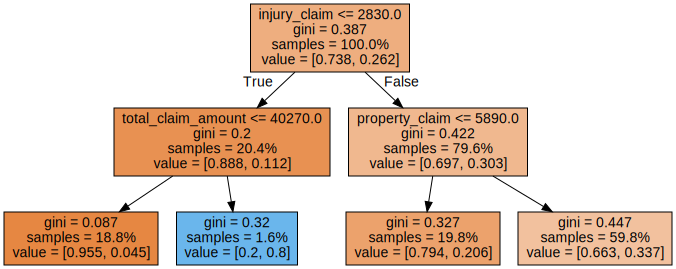

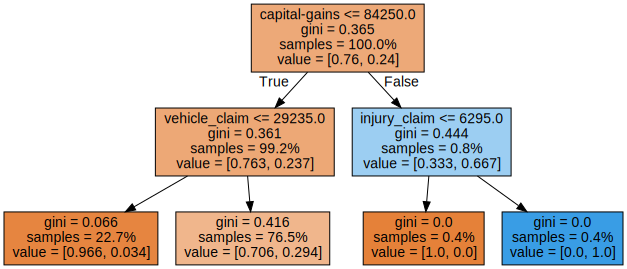

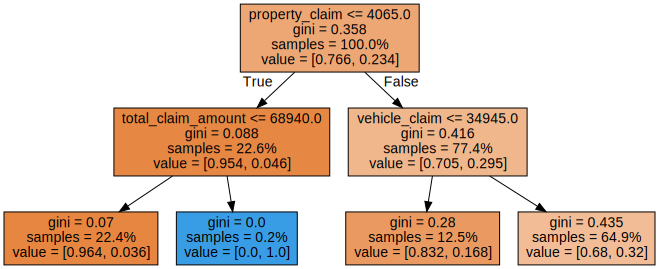

In [8]:
#Visualise and export tree structure
#only 3 trees
for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,   
                               impurity=True, 
                               proportion=True
                                )
    graph = graphviz.Source(dot_data)
    display(graph)
    #graph.render(f'tree_{i}') #graph will be exported in pdf file

### Hyperparameters tuning

In [9]:
model = RandomForestClassifier(random_state= 0, bootstrap=True ) #control the randomness of bootstrapping
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.72


In [11]:
param_dist = {'n_estimators': randint(50,200),
              'max_depth': randint(1,20)}

# Create a random forest classifier
model1 = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model1, 
                                 param_distributions = param_dist, 
                                 n_iter=10, #only try out 10 settings
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001682221D310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016822278910>})

In [12]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 155}


In [13]:
model2 = RandomForestClassifier(n_estimators=155, max_depth=3, random_state= 0)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy2)
#accuracy is higher

Accuracy: 0.755


Or by hand 

In [14]:
n_estimators = [100, 150, 200, 220, 250]
max_depth_range = [2,3,4,5]
hyperparameter_df = pd.DataFrame(columns=['n_estimators','max_depth','accuracy'])

for n_esti in n_estimators:
    for max_depth in max_depth_range:
        #print(f'n_estimators: {n_esti} max_depth: {max_depth}')
        
        model = RandomForestClassifier(n_estimators= n_esti, max_depth= max_depth)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
       # print("Accuracy:", accuracy)    
        
        hyperparameter_df.loc[len(hyperparameter_df)] = n_esti, max_depth, accuracy

print("\nDone.")
hyperparameter_df



Done.


,n_estimators,max_depth,accuracy
0,100.0,2.0,0.755
1,100.0,3.0,0.755
2,100.0,4.0,0.755
3,100.0,5.0,0.755
4,150.0,2.0,0.755
5,150.0,3.0,0.755
6,150.0,4.0,0.755
7,150.0,5.0,0.755
8,200.0,2.0,0.755
9,200.0,3.0,0.755


The highest possible accuracy is 75.5 and the best hyperparameters are maybe n_estimators = 100 and max_depth = 2

In [15]:
model2 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state= 0)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy2)
#model2.estimators_

Accuracy: 0.755


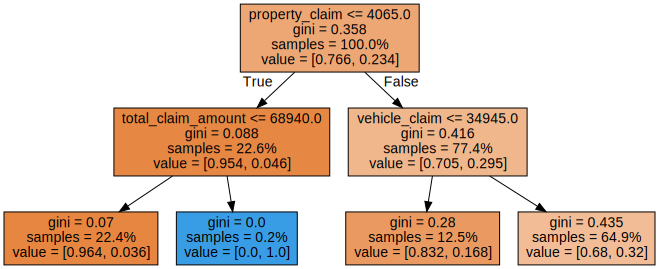

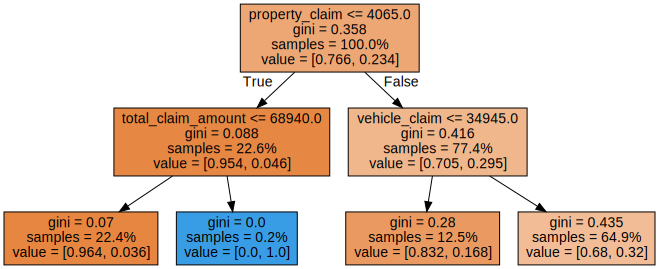

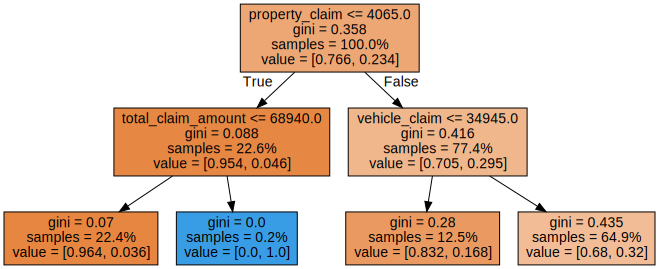

In [17]:
for i in range(3):
    tree2 = model2.estimators_[i]
    dot_data2 = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,   
                               impurity=True, 
                               proportion=True,
                               max_depth= 2)
    graph2 = graphviz.Source(dot_data)
    display(graph2)
    graph2.render(f'tree_100_2_Nr{i}') #graph will be exported in pdf file